In [1]:
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg, pandas as pd, math, statistics
from sklearn.ensemble import IsolationForest
from PIL import Image
from scipy import ndimage
from matplotlib import rcParams

# base directory should contain 1 or more matched "pairs" of images suitable for calibration
# ideal imagery for calibration includes near-sea level land at the interior margin

base_dir = r"D:\Example_datasets\Waldo_datasets\unspecific_pairs\8_03_22-uncropped"
# the file extension of the imagery. We could code a different way to read in images, but this works.
img_ext = "jpg"

img_list = glob.glob(f"{base_dir}//*.jpg", recursive=True)

# identify all file pairs with the same name aside from the first character
pair_list = np.unique([i.split("\\")[-1][1:] for i in img_list], return_counts=True)
pair_list = pair_list[0][pair_list[1]==2]
# this variable sets left vs. right prefixes for the image files
prefixes = {'right':0, 'left':1}
pairs = [{k: f"{base_dir}\\{v}{i}" for k, v in prefixes.items()} for i in pair_list]

# change the index number ("0") to change the pair
trgt_pair = pairs[2]
print(trgt_pair)

{'right': 'D:\\Example_datasets\\Waldo_datasets\\unspecific_pairs\\8_03_22-uncropped\\0_000_00_278.jpg', 'left': 'D:\\Example_datasets\\Waldo_datasets\\unspecific_pairs\\8_03_22-uncropped\\1_000_00_278.jpg'}


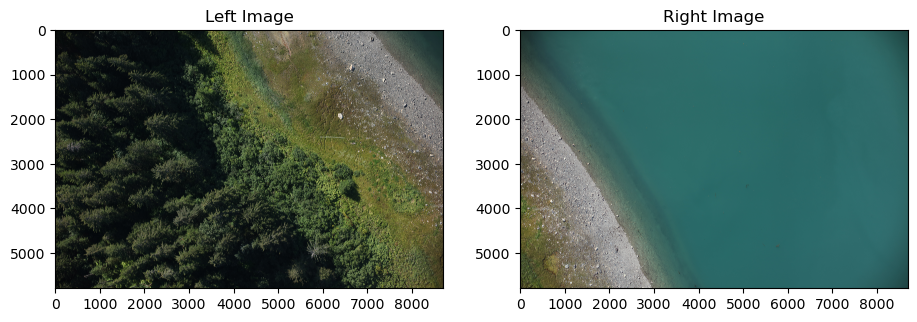

In [2]:
# this section reads in the images and displays them
img_l = mpimg.imread(trgt_pair["left"])
img_r = ndimage.rotate(mpimg.imread(trgt_pair["right"]), 180)

im_height, im_width, im_channels = img_l.shape

def display_image_pair(left_image, right_image):
    rcParams['figure.figsize'] = 11 ,8
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(left_image)
    ax[1].imshow(right_image)
    ax[0].set_title("Left Image")
    ax[1].set_title("Right Image")

display_image_pair(img_l, img_r)
# crop images to 500 pixel inner margin

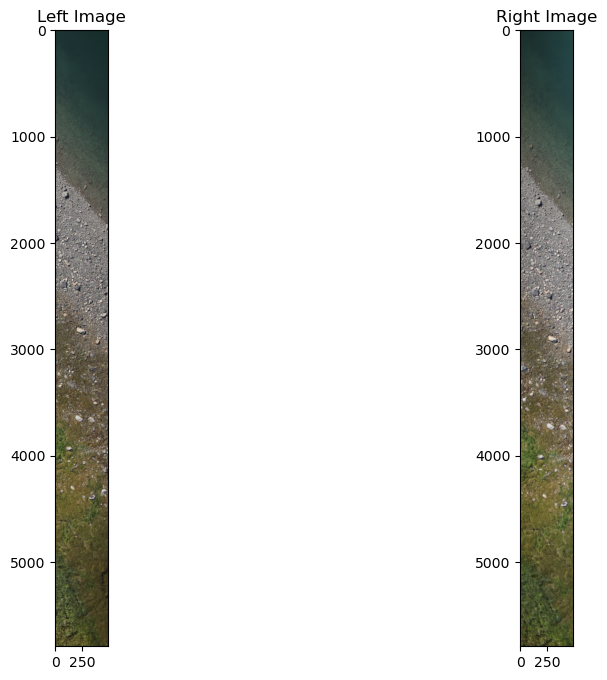

In [3]:
# this section crops the images to just the inner margin where we expect overlap
# to reduce the number of spurious tie points possible
inner_margin = 500
img1 = img_l[0:im_height, im_width-inner_margin:im_width]
img2 = img_r[0:im_height, 0:inner_margin]
display_image_pair(img1, img2)

In [4]:
# This section generates 100,000 potential keypoints and formats them for handling

# Initialize ORB detector
orb = cv2.ORB_create(100000)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Use BFMatcher to find matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

des1 = des1.astype(np.float32)
des2 = des2.astype(np.float32)

# Create dataframe with distance and slope between points
def slope(p1, p2):
    if p2[0] == p1[0]:
        return (p2[1]-p1[1])/0.00001
    else: return (p2[1]-p1[1])/(p2[0]-p1[0])

df = pd.DataFrame([[mat, kp1[mat.queryIdx], kp1[mat.queryIdx].pt, kp2[mat.trainIdx], kp2[mat.trainIdx].pt] for mat in matches], columns=['matches', 'kp1', 'kp1.pt','kp2', 'kp2.pt'])
df["distance"] = [math.dist(i.kp1.pt, i.kp2.pt) for i in df.itertuples()]
df["slope"] = [slope(i.kp1.pt, i.kp2.pt) for i in df.itertuples()]

In [5]:
# This section pares down the dataframe (potential tiepoints)
# using an outlier removal algorithm called IsolationForest

# algorithm will repeat outlier removal based on distance and slope
# until all slopes fall within range of tolerance (variable below)
slope_tolerance = 1

while (max(df.slope) - min(df.slope) > slope_tolerance):
    clf = IsolationForest().fit(df[['distance', 'slope']])
    results = clf.predict(df[['distance', 'slope']])
    results = list([results == 1][0])
    df = df[results]

    #I repeat the outlier removal on only distance each round
    # to complement the slope filter criterion
    clf = IsolationForest().fit(df[['distance']])
    results = clf.predict(df[['distance']])
    results = list([results == 1][0])
    df = df[results]
    print("culling")


culling
culling
culling


In [11]:
# this section displays the matches on the cropped imagery.
# Press Q key to close the window and proceed when finished.
# I'm not convinced this is a perfect drawing (I always see a couple spurious ties)
# but it seems mostly accurate. I'm new to this set of tools.

display_matches = True
if display_matches == True:
    img_matches = cv2.drawMatches(
        img1, kp1, img2, kp2, list(df.matches), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    cv2.namedWindow('matches', cv2.WINDOW_NORMAL)
    cv2.imshow("matches", img_matches)
    wait_time = 1000
    while cv2.getWindowProperty('matches', cv2.WND_PROP_VISIBLE) >= 1:
        keyCode = cv2.waitKey(wait_time)
        if (keyCode & 0xFF) == ord("q"):
            cv2.destroyAllWindows()
            break

In [7]:
# This section looks at the horizontal displacement of features
# and calculates their distance to the edge of the image to determine
# the total size of the overlap zone

df['kp1_pt_orig_x'] = [i[0]+im_width-(inner_margin+1) for i in df['kp1.pt']]
df['kp2_pt_orig_x'] = [i[0] for i in df['kp2.pt']]
df['kp1_pt_orig_y'] = [i[0] for i in df['kp1.pt']]
df['kp2_pt_orig_y'] = [i[0] for i in df['kp2.pt']]
vertical_displacement = df['kp2_pt_orig_y']-df['kp1_pt_orig_y']
df = df.sort_values('kp1_pt_orig_x', ascending=False)
edge_of_im1_on_im2 = margin_r = statistics.median([i.kp2_pt_orig_x + (im_width-i.kp1_pt_orig_x) for i in df.itertuples()][0:int(len(df)/20)])
df = df.sort_values('kp2_pt_orig_x', ascending=True)
edge_of_im2_on_im1 = statistics.median([i.kp1_pt_orig_x - i.kp2_pt_orig_x for i in df.itertuples()][0:int(len(df)/20)])
margin_l = im_width - edge_of_im2_on_im1
mean_margin = statistics.mean([margin_l, margin_r])

# this bit just digests and presents key metrics of overlap

print(f"Average vertical displacement of {round(statistics.mean(vertical_displacement), 2)} pixels from left image to right")
print(f"Average of {round(mean_margin, 2)} pixels in horizontal overlap zone")
dead_center = mean_margin/2
print(f"Crop at least {math.ceil(dead_center)} pixels to eliminate overlap")
percent_overlap = mean_margin/im_width
print(f"{round(percent_overlap, 4)}% of each image overlaps its partner")
waldo_aovw = 39.597752709049864
angle_of_overlap = percent_overlap * waldo_aovw
print(f"Fields of view extend {round(angle_of_overlap, 2)}° past nadir")
waldo_angle = waldo_aovw - angle_of_overlap
print(f"Waldos were mounted {round(waldo_angle, 2)}° apart")

Average vertical displacement of 61.81 pixels from left image to right
Average of 562.68 pixels in horizontal overlap zone
Crop at least 282 pixels to eliminate overlap
0.0648% of each image overlaps its partner
Fields of view extend 2.56° past nadir
Waldos were mounted 37.03° apart
